<a href="https://colab.research.google.com/github/Liraken/P04-Weather-Risk/blob/main/Project4_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:

!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.5 MB/s eta 0:00:00


In [157]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import files
from tensorflow_addons.metrics import r_square

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
uploaded = files.upload()

Saving processed_storm_data.csv to processed_storm_data.csv


In [76]:
df=pd.read_csv('processed_storm_data.csv')
df.head()

,Unnamed: 0,BEGIN_DATE_TIME,DAMAGE_PROPERTY,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,DURATION_SEC,REGION_NORTHEAST,REGION_NORTHERN ROCKIES AND PLAINS,...,EVENT_TYPE_Strong Wind,EVENT_TYPE_Thunderstorm Wind,EVENT_TYPE_Tornado,EVENT_TYPE_Tropical Depression,EVENT_TYPE_Tropical Storm,EVENT_TYPE_Tsunami,EVENT_TYPE_Waterspout,EVENT_TYPE_Wildfire,EVENT_TYPE_Winter Storm,EVENT_TYPE_Winter Weather
0,0,1994-03-27 11:32:00,5000000.0,34.43,-85.98,34.47,-85.78,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,1994-05-15 19:30:00,0.0,NaN,NaN,NaN,NaN,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2,1994-06-26 22:20:00,500000.0,NaN,NaN,NaN,NaN,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,3,1994-05-15 13:47:00,0.0,NaN,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1994-03-27 15:50:00,0.0,NaN,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
df['BEGIN_DATE_TIME']=df['BEGIN_DATE_TIME'].astype('datetime64[ns]')

In [78]:
df['BEGIN_DATE_TIME']=df['BEGIN_DATE_TIME'].dt.to_period('M')
df['BEGIN_DATE_TIME']=df['BEGIN_DATE_TIME'].astype('datetime64[ns]')

In [79]:
df['BEGIN_DATE_TIME'] = df['BEGIN_DATE_TIME'].map(pd.Timestamp.timestamp)

In [80]:
df=df.drop(columns=['Unnamed: 0', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON'])

In [81]:
df.sort_values(by='BEGIN_DATE_TIME', ascending=True, inplace=True)

In [82]:
df.head()

,BEGIN_DATE_TIME,DAMAGE_PROPERTY,DURATION_SEC,REGION_NORTHEAST,REGION_NORTHERN ROCKIES AND PLAINS,REGION_NORTHWEST,REGION_OHIO VALLEY,REGION_SOUTH,REGION_SOUTHEAST,REGION_SOUTHWEST,...,EVENT_TYPE_Strong Wind,EVENT_TYPE_Thunderstorm Wind,EVENT_TYPE_Tornado,EVENT_TYPE_Tropical Depression,EVENT_TYPE_Tropical Storm,EVENT_TYPE_Tsunami,EVENT_TYPE_Waterspout,EVENT_TYPE_Wildfire,EVENT_TYPE_Winter Storm,EVENT_TYPE_Winter Weather
14103,757382400.0,500000.0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
14104,757382400.0,5000.0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
14138,757382400.0,0.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14139,757382400.0,500.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14426,757382400.0,500.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
df.dtypes

BEGIN_DATE_TIME                       float64
DAMAGE_PROPERTY                       float64
DURATION_SEC                            int64
REGION_NORTHEAST                        int64
REGION_NORTHERN ROCKIES AND PLAINS      int64
REGION_NORTHWEST                        int64
REGION_OHIO VALLEY                      int64
REGION_SOUTH                            int64
REGION_SOUTHEAST                        int64
REGION_SOUTHWEST                        int64
REGION_UPPER MIDWEST                    int64
REGION_WEST                             int64
EVENT_TYPE_Astronomical Low Tide        int64
EVENT_TYPE_Avalanche                    int64
EVENT_TYPE_Blizzard                     int64
EVENT_TYPE_Coastal Flood                int64
EVENT_TYPE_Cold/Wind Chill              int64
EVENT_TYPE_Debris Flow                  int64
EVENT_TYPE_Dense Fog                    int64
EVENT_TYPE_Dense Smoke                  int64
EVENT_TYPE_Drought                      int64
EVENT_TYPE_Dust Devil             

In [95]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [96]:
scaler=tf.keras.layers.experimental.preprocessing.Normalization()
scaler.adapt(train_df)
train_df=pd.DataFrame(scaler(train_df).numpy(),columns=df.columns)
val_df=pd.DataFrame(scaler(val_df),columns=df.columns)
test_df=pd.DataFrame(scaler(test_df),columns=df.columns)

In [97]:
train_df

,BEGIN_DATE_TIME,DAMAGE_PROPERTY,DURATION_SEC,REGION_NORTHEAST,REGION_NORTHERN ROCKIES AND PLAINS,REGION_NORTHWEST,REGION_OHIO VALLEY,REGION_SOUTH,REGION_SOUTHEAST,REGION_SOUTHWEST,...,EVENT_TYPE_Strong Wind,EVENT_TYPE_Thunderstorm Wind,EVENT_TYPE_Tornado,EVENT_TYPE_Tropical Depression,EVENT_TYPE_Tropical Storm,EVENT_TYPE_Tsunami,EVENT_TYPE_Waterspout,EVENT_TYPE_Wildfire,EVENT_TYPE_Winter Storm,EVENT_TYPE_Winter Weather
0,-2.204098,0.005017,-0.199402,-0.349234,-0.350684,-0.119996,-0.491295,-0.576056,2.382589,-0.223005,...,-0.121633,-0.688521,5.425700,-0.018093,-0.047621,-0.00464,-0.013043,-0.059877,-0.190017,-0.187683
1,-2.204098,-0.011222,-0.199402,-0.349234,-0.350684,-0.119996,-0.491295,-0.576056,2.382589,-0.223005,...,-0.121633,-0.688521,5.425700,-0.018093,-0.047621,-0.00464,-0.013043,-0.059877,-0.190017,-0.187683
2,-2.204098,-0.011386,-0.199402,-0.349234,-0.350684,-0.119996,-0.491295,1.735982,-0.419716,-0.223005,...,-0.121633,-0.688521,-0.184311,-0.018093,-0.047621,-0.00464,-0.013043,-0.059877,-0.190017,-0.187683
3,-2.204098,-0.011370,-0.199402,-0.349234,-0.350684,-0.119996,-0.491295,1.735982,-0.419716,-0.223005,...,-0.121633,-0.688521,-0.184311,-0.018093,-0.047621,-0.00464,-0.013043,-0.059877,-0.190017,-0.187683
4,-2.204098,-0.011370,-0.199402,-0.349234,-0.350684,-0.119996,-0.491295,1.735982,-0.419716,-0.223005,...,-0.121633,-0.688521,-0.184311,-0.018093,-0.047621,-0.00464,-0.013043,-0.059877,-0.190017,-0.187683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929099,1.530023,-0.011058,-0.199402,-0.349234,-0.350684,-0.119996,-0.491295,-0.576056,2.382589,-0.223005,...,-0.121633,1.452409,-0.184311,-0.018093,-0.047621,-0.00464,-0.013043,-0.059877,-0.190017,-0.187683
929100,1.530023,-0.011386,-0.199402,-0.349234,-0.350684,-0.119996,-0.491295,-0.576056,2.382589,-0.223005,...,-0.121633,1.452409,-0.184311,-0.018093,-0.047621,-0.00464,-0.013043,-0.059877,-0.190017,-0.187683
929101,1.530023,-0.011386,-0.199402,-0.349234,-0.350684,-0.119996,-0.491295,-0.576056,2.382589,-0.223005,...,-0.121633,1.452409,-0.184311,-0.018093,-0.047621,-0.00464,-0.013043,-0.059877,-0.190017,-0.187683
929102,1.530023,-0.011386,-0.199402,-0.349234,-0.350684,-0.119996,-0.491295,-0.576056,2.382589,-0.223005,...,-0.121633,-0.688521,-0.184311,-0.018093,-0.047621,-0.00464,-0.013043,-0.059877,-0.190017,-0.187683


In [98]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [99]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [110]:
def plot(self, model=None, plot_col='DAMAGE_PROPERTY', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [M]')

WindowGenerator.plot = plot

In [101]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [102]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [103]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [104]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['DAMAGE_PROPERTY'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['DAMAGE_PROPERTY']

In [105]:
baseline = Baseline(label_index=column_indices['DAMAGE_PROPERTY'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

8296/8296 [==============================] - 14s 2ms/step - loss: 5.6689 - mean_absolute_error: 0.0345


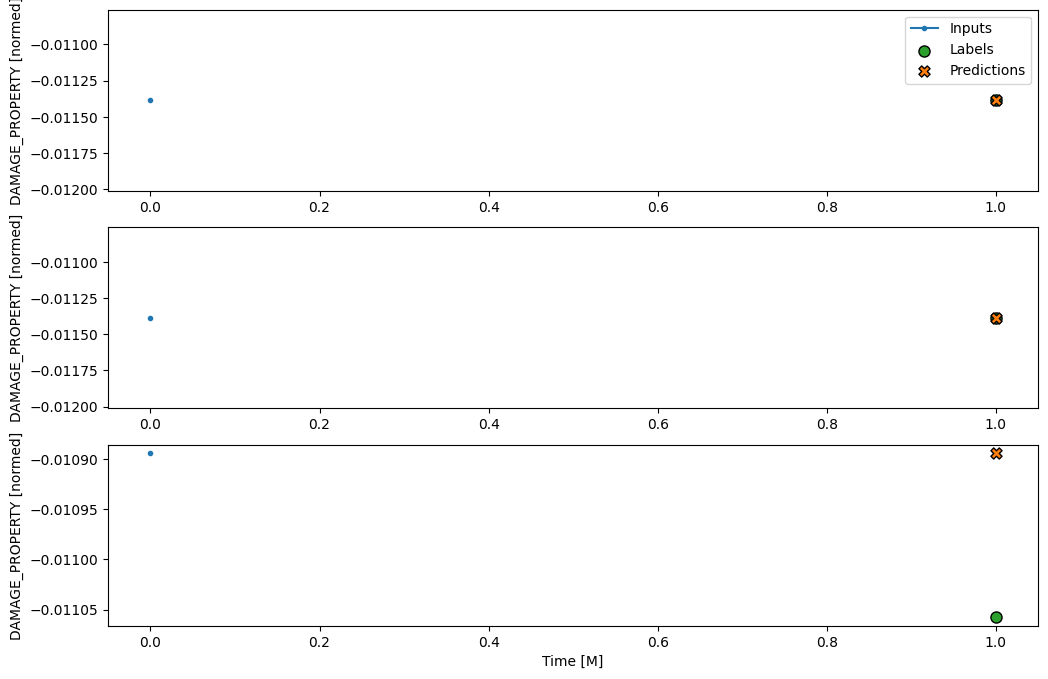

In [111]:
single_step_window.plot(baseline)

In [119]:
wide_window = WindowGenerator(
    input_width=1000, label_width=1000, shift=10,
    label_columns=['DAMAGE_PROPERTY'])

wide_window

Total window size: 1010
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236

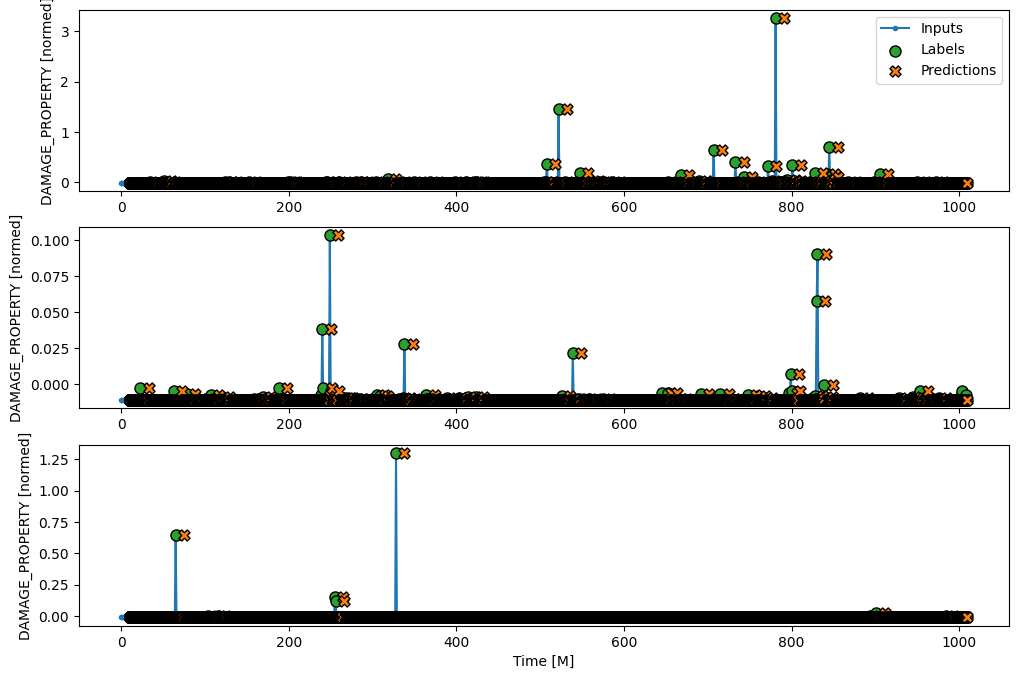

In [120]:
wide_window.plot(baseline)

In [153]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tensorflow_addons.metrics.RSquared()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [108]:
len(train_df)

929104

In [ ]:
LABEL_WIDTH =
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['DAMAGE_PROPERTY'])

wide_conv_window

In [145]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [121]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 1000, 58)
Output shape: (32, 1000, 1)


In [154]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

NameError: name 'tensorflow_saddons' is not defined

In [123]:
cm = lstm_model.metrics[1]
cm.metrics

[]

In [124]:
val_performance

{'Baseline': {'loss': 5.66888952255249,
  'mean_absolute_error': 0.03449398651719093},
 'LSTM': {'loss': 3.707303047180176,
  'mean_absolute_error': 0.10295814275741577}}

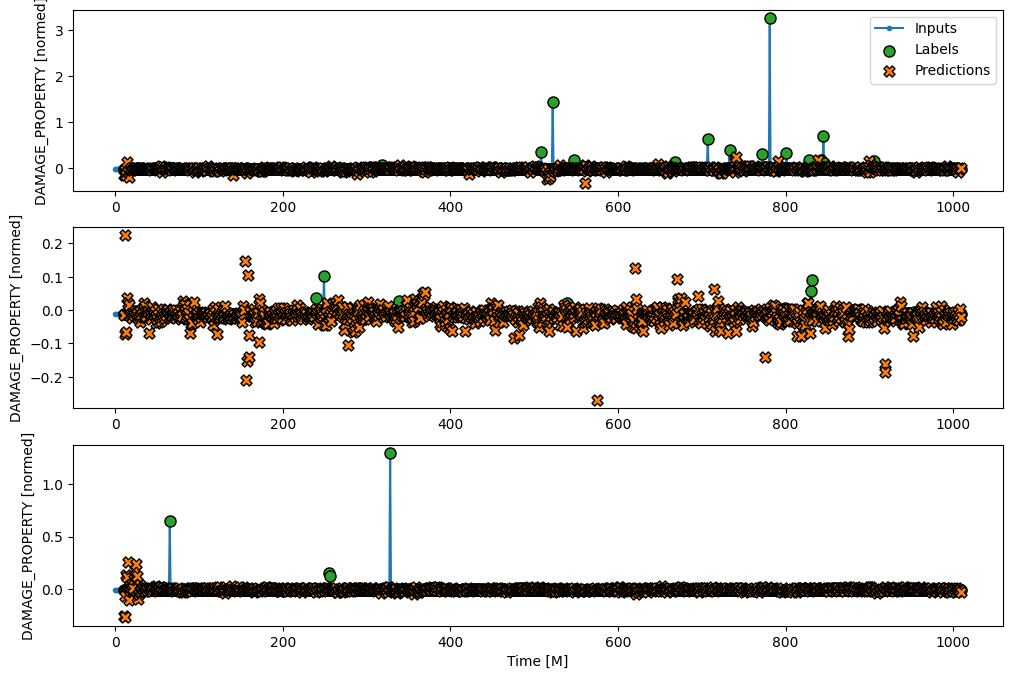

In [127]:
wide_window.plot(lstm_model)

In [138]:
cm=lstm_model.metrics[1]


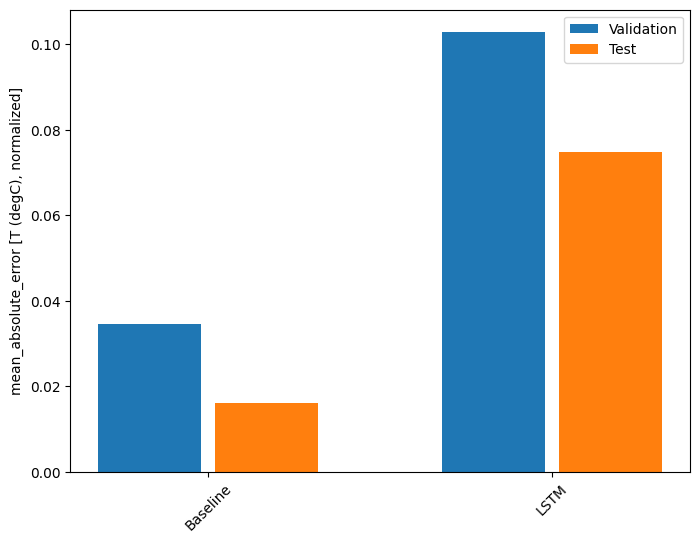

In [130]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [159]:
from sklearn.metrics import r2_score

# Get predictions from the model
predictions = lstm_model.predict(wide_window.test)

# Calculate the R^2 score
r2 = r2_score(wide_window.test, predictions)

# Print the R^2 score
print(f"R^2 score: {r2}")

4117/4117 [==============================] - 62s 15ms/step


ValueError: Found input variables with inconsistent numbers of samples: [4117, 131721]